Text(0.5, 1, 'Autoregressive Process')

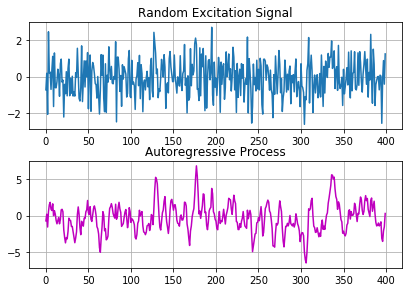

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Length of time series
#
N = 400

# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)

# Second order AR Process
#
a = np.array([1.2, -0.4])

S = ex.copy();
for n in range(2,N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, a) + ex[n]
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
plt.tight_layout()

ax[0].plot(range(N), ex)
ax[0].grid(True)
ax[0].set_title("Random Excitation Signal")

ax[1].plot(range(N), S, color='m')
ax[1].grid(True)
ax[1].set_title("Autoregressive Process")

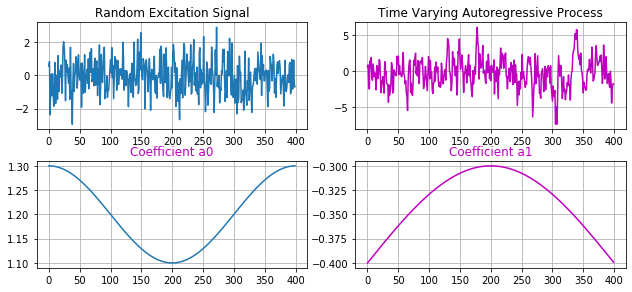

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

# Length of time series
#
N = 400

# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)

# Second order AR Process with coefficients slowly changing in time
#
a = np.array([1.2, -0.4])
A = np.zeros((N,2))
omega, alpha = N/2, 0.1

for n in range(N):
    A[n,0] = a[0] + alpha * np.cos(2*np.pi*n/N)
    A[n,1] = a[1] + alpha * np.sin(np.pi*n/N)

S_t = ex.copy()
for n in range(2,N):
    x = np.array([S[n-1], S[n-2]])
    S_t[n] = np.dot(x, A[n,:]) + ex[n]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,4))
plt.tight_layout()

ax[0,0].plot(range(N), ex)
ax[0,0].grid(True)
ax[0,0].set_title("Random Excitation Signal")

ax[0,1].plot(range(N), S_t, color='m')
ax[0,1].grid(True)
ax[0,1].set_title("Time Varying Autoregressive Process")

ax[1,0].plot(range(N), A[:,0])
ax[1,0].grid(True)
ax[1,0].set_title("Coefficient a0", color='m')

ax[1,1].plot(range(N), A[:,1], color='m')
ax[1,1].grid(True)
ax[1,1].set_title("Coefficient a1", color='m')

plt.savefig("arChange.png")

[ 1.2 -0.4]
[[-1.5017935 ]
 [ 0.27711085]]


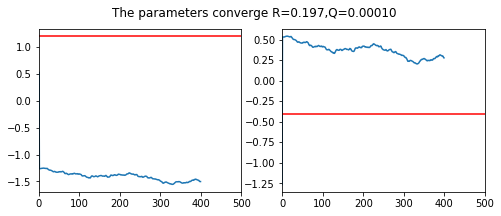

In [5]:
# Time series data y
# th_n_n: estimate at time n using all data upto time n
# th_n_n1: estimate at time n using all data upto time n-1
#

# Initialize  
#
x = np.zeros((2,1))
th_n1_n1 = np.random.randn(2,1)
P_n1_n1 = 0.001*np.eye(2)
y = S.copy()
ePlot = np.zeros((400,1))

# Noise variances -- hyperparameters (to be tuned)
# Set measurement noise as fraction of data variance (first few samples)
# Guess for process noise 
#
R = 0.2*np.std(ex[0:10])
beta = 0.0001
Q  = beta*np.eye(2)

# Space to store and plot
#
th_conv = np.zeros([2, N])

# First two estimates are initial guesses
#
th_conv[0,0] = th_n1_n1[0]
th_conv[0,1] = th_n1_n1[1]
th_conv[1,0] = th_n1_n1[0]
th_conv[1,1] = th_n1_n1[1]

# Kalman Iteration Loop (univariate observation, start from time step 2)
#
for n in range(2,N):
    # Input Vector contains past values
    x[0] = y[n-1]
    x[1] = y[n-2]
    
    # Prediction of state and covariance
    th_n_n1 = th_n1_n1.copy()
    P_n_n1 = P_n1_n1 + Q
    
    yh = th_n_n1.T @ x
    en = y[n] - yh
    ePlot[n] = en
    
    # Kalman gain (kn) and innovation variance (den)
    #
    den = x.T @ P_n1_n1 @ x + R
    kn = P_n1_n1 @ x / den
    
    # Posterior update
    #
    th_n_n = th_n_n1 + kn * en
    P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1
    
    # Save
    th_conv[0,n] = th_n_n[0]
    th_conv[1,n] = th_n_n[1]
    
    # Remeber for next step
    #
    th_n1_n1 = th_n_n.copy()
    P_n1_n1 = P_n_n.copy()
    
print(a)
print(th_n_n)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
fig.suptitle("The parameters converge R=%4.3f,Q=%6.5f"%(R,beta))
ax[0].plot(th_conv[0])
ax[0].set_xlim(0,500)
ax[0].axhline(y=a[0], color='r')


ax[1].plot(th_conv[1])
ax[1].set_xlim(0,500)
ax[1].axhline(y=a[1], color='r')

Text(0.5, 1.0, 'Initial Particles')

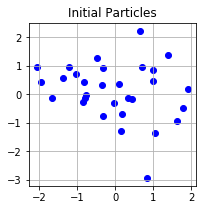

In [4]:
Ns = 30

# initial particles
#
parts = np.random.randn(Ns, 2)

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(parts[:,0], parts[:,1], color='b')
ax.grid(True)
ax.set_title("Initial Particles")

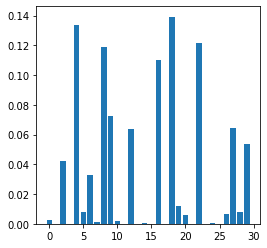

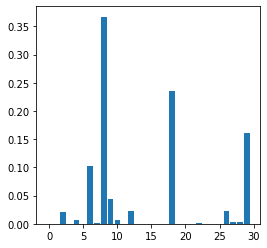

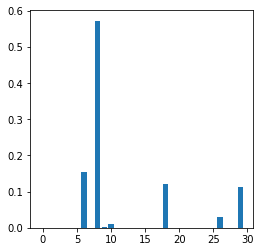

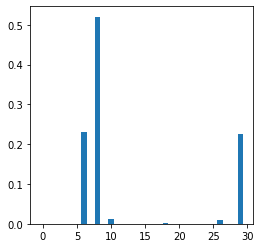

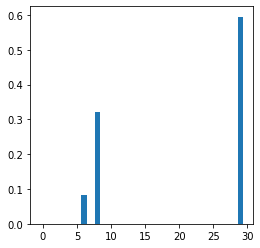

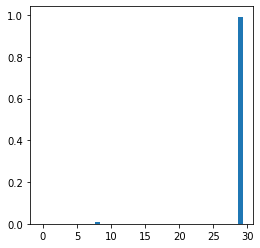

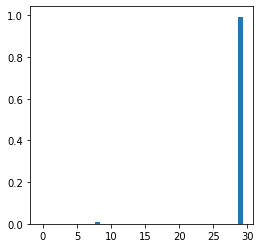

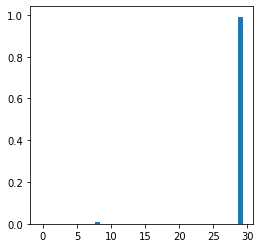

In [5]:
# Likelihood from Gaussian noise
# Needs estimate, true value and noise variance
def particle_likelihood(y0, yh, sig):
    lhood = (1/(2*np.pi*sig))*np.exp(-0.5*(y0-yh)**2)
    return  lhood

# Process noise covariance is beta*I
#
beta = 0.01

# Observation noise variance
#
sig = np.std(ex)

# Initial input vector and particle weights
#
x = np.zeros((2,1))
pweights = np.ones((Ns,1)) / Ns

# Go over the data
#
for n in range(2, 10):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    # Sample particles from the prior
    # (in the simplest case here, random perturbation)
    #
    for p in range(Ns):
        parts[p,:] = parts[p,:] + beta*np.random.randn(1,2)
        
    # Predictions and likelihoods
    #
    sh = np.zeros((Ns, 1))
    lhoods = sh.copy()
    for particle in range(Ns):
        th = parts[particle,:].T.copy()
        sh[particle] = x.T @ th
        lhoods[particle] = particle_likelihood(S[n], sh[particle], sig)
        
    # multiply prior weights by likelihoods and normalize
    #
    pweights = pweights * lhoods
    pweights = pweights / np.sum(pweights)
    
    # Observe how the weights change as you update
    #
    fig, ax = plt.subplots(figsize=(4,4))
    ax.bar(np.arange(len(pweights)), pweights[:,0])

In [6]:
def resample(parts,pweights):
    c = np.zeros(Ns)
    u = np.zeros(Ns)

    partsx = np.random.randn(Ns, 2)
    pweightsx = np.ones((Ns,1))
    c[0] = pweights[0]

    for i in range(1,Ns):
        c[i] = c[i-1] + pweights[i]
    #print(c)
    u[0]  = random.uniform(0,1/Ns)

    i = 0
    for j in range(Ns):
        u[j] = u[0] + 1/(Ns)*j
        while u[j] > c[i]:
            i += 1
        partsx[j] = parts[i]
        pweightsx[j] = 1/Ns
    return partsx,pweightsx

C:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

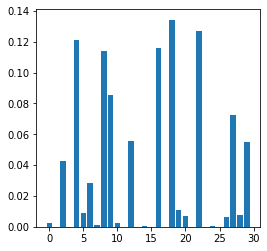

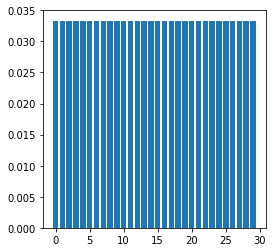

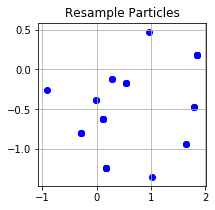

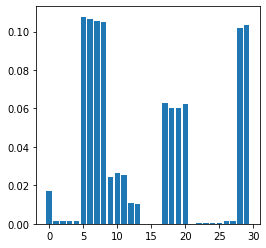

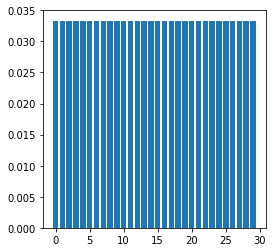

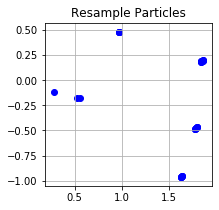

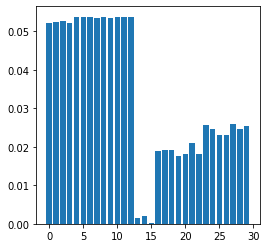

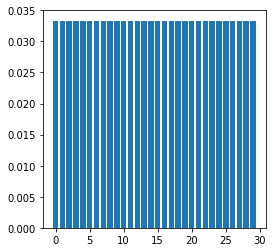

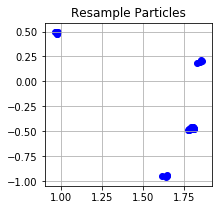

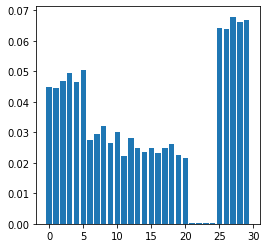

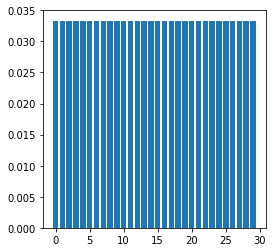

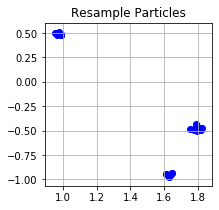

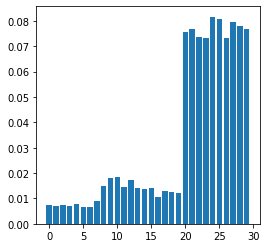

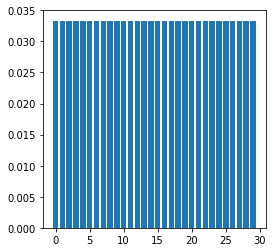

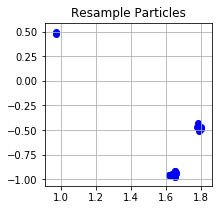

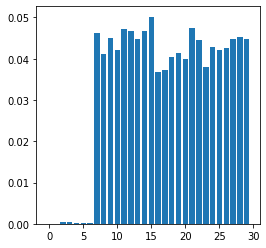

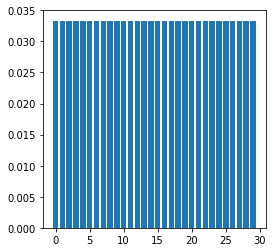

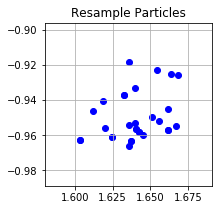

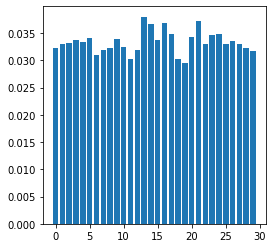

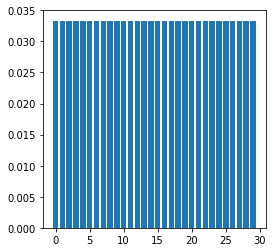

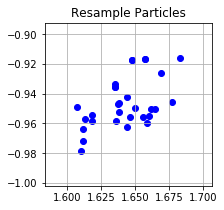

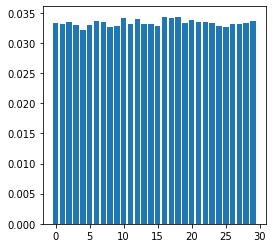

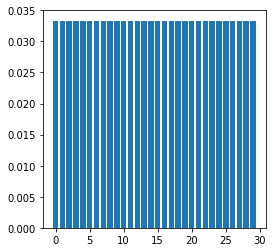

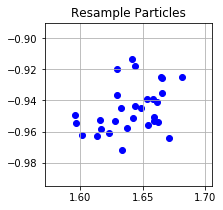

In [7]:
# Likelihood from Gaussian noise
# Needs estimate, true value and noise variance
def particle_likelihood(y0, yh, sig):
    lhood = (1/(2*np.pi*sig))*np.exp(-0.5*(y0-yh)**2)
    return  lhood

# Process noise covariance is beta*I
#
beta = 0.01

# Observation noise variance
#
sig = np.std(ex)

# Initial input vector and particle weights
#
x = np.zeros((2,1))
pweights = np.ones((Ns,1)) / Ns

# Go over the data
#
for n in range(2, 10):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    # Sample particles from the prior
    # (in the simplest case here, random perturbation)
    #
    for p in range(Ns):
        parts[p,:] = parts[p,:] + beta*np.random.randn(1,2)
        
    # Predictions and likelihoods
    #
    sh = np.zeros((Ns, 1))
    lhoods = sh.copy()
    for particle in range(Ns):
        th = parts[particle,:].T.copy()
        sh[particle] = x.T @ th
        lhoods[particle] = particle_likelihood(S[n], sh[particle], sig)
        
    # multiply prior weights by likelihoods and normalize
    #
    pweights = pweights * lhoods
    pweights = pweights / np.sum(pweights)
    
    # Observe how the weights change as you update
    #
    fig, ax = plt.subplots(figsize=(4,4))
    ax.bar(np.arange(len(pweights)), pweights[:,0])
    parts, pweights = resample(parts,pweights)
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.bar(np.arange(len(pweights)), pweights[:,0])
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(parts[:,0], parts[:,1], color='b')
    ax.grid(True)
    ax.set_title("Resample Particles")

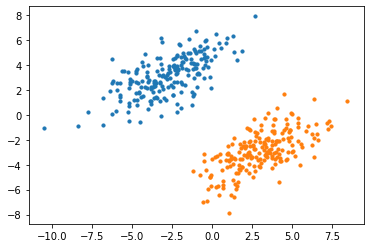

In [8]:
# Generating Data for Logistic Regression Classifier
NumDataPerClass = 200
alpha = 3

m1 = [[-alpha, alpha]]
m2 = [[alpha, -alpha]]
C = [[2,1],[1,2]]
ex = np.random.randn(NumDataPerClass*2)
A = np.linalg.cholesky(C)

X1 = np.random.randn(NumDataPerClass,2)
Y1 = X1 @ A + m1
T1 = np.zeros(NumDataPerClass)
X2 = np.random.randn(NumDataPerClass,2)
Y2 = X2 @ A + m2
T2 = np.ones(NumDataPerClass)

for i in range(NumDataPerClass):
    Y1[i,:] += ex[i]
    Y2[i,:] += ex[i+NumDataPerClass]

Data = Y1.copy()
Data = np.append(Data,Y2,axis=0)
Target = T1.copy()
Target = np.append(Target,T2)

plt.scatter(Y1[:,0],Y1[:,1],s=10)
plt.scatter(Y2[:,0],Y2[:,1],s=10)

In [10]:
def cross_entropy(a, y):
    return np.sum(-y*np.log(a)-(1-y)*np.log(1-a))

# Initialize
th_n1_n1 = np.random.randn(2,1)
P_n1_n1 = 0.001*np.eye(2)

R = 0.2*np.std(ex[0:10])
beta = 0.0001
Q = beta*np.eye(2)
th = np.zeros((801,2))
th[0] = th_n1_n1.reshape(1,2)

# Space to store and plot
#
th_conv = np.zeros([2, N])

# First two estimates are initial guesses
#
th_conv[0,0] = th_n1_n1[0]
th_conv[0,1] = th_n1_n1[1]
th_conv[1,0] = th_n1_n1[0]
th_conv[1,1] = th_n1_n1[1]

for i in range(4*NumDataPerClass):
    j = np.floor(np.random.rand()*2*NumDataPerClass).astype(int)
    x = Data[j].reshape(2,1)
    
    th_n_n1 = th_n1_n1.copy()
    P_n_n1 = P_n1_n1 + Q
    
    yh = 1 / (1 + np.exp(-th_n_n1.T @ x))
    en = cross_entropy(yh,Target[j])
    ePlot[i] = en
    
    # Kalman gain (kn) and innovation variance (den)
    #
    den = x.T @ P_n1_n1 @ x + R
    kn = P_n1_n1 @ x / den
    
    # Posterior update
    #
    th_n_n = th_n_n1 + kn * en
    P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1
    
    # Save
    th[i+1] = th_n_n.reshape(1,2)
    
    # Remeber for next step
    #
    th_n1_n1 = th_n_n.copy()
    P_n1_n1 = P_n_n.copy() 

plt.scatter(Y1[:,0],Y1[:,1],s=10)
plt.scatter(Y2[:,0],Y2[:,1],s=10)
x = np.arange(-10, 10, 0.1)
y = -th_n_n[0]/th_n_n[1] * x

z = 1 / (1 + np.exp(-th_n_n1.T @ [-7.5,7.5]))
print(z)
z = 1 / (1 + np.exp(-th_n_n1.T @ [7.0,-7.5]))
print(z)
plt.plot(x,y)
#plt.contourf(x,y,z)

IndexError: index 400 is out of bounds for axis 0 with size 400

In [ ]:
plt.scatter(Y1[:,0],Y1[:,1],s=10)
plt.scatter(Y2[:,0],Y2[:,1],s=10)
x = np.arange(-10, 10, 0.1)
for i in range(th.shape[0]):
    y = -th[i][0]/th[i][1] * x
    plt.plot(x,y)
z = 1 / (1 + np.exp(-th_n_n1.T @ [-7.5,7.5]))
print(z)
z = 1 / (1 + np.exp(-th_n_n1.T @ [7.0,-7.5]))
print(z)
